# Bibliotecas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from networkx.algorithms import bipartite
from scipy.integrate import odeint
from scipy import stats

# Contrução da Rede

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/Base de dados (GeoSymbio)/Arquivos editáveis para teste/EDITAVEL_GeoSymbio_Data.csv",encoding="windows-1252")
host_simb_assoc = df.groupby(["Type_and_StateRegion", "Host_and_StateRegion"]).size().reset_index(name='Count')

In [ ]:
B_1 = nx.Graph()

for i in range(len(host_simb_assoc[["Type_and_StateRegion"]].values)):
  B_1.add_node(host_simb_assoc.loc[i]["Type_and_StateRegion"], bipartite = 0, simb_tol = df['Symb_Tol'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], state_reg = df['StateRegion'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], T_MMM_05 = df['T_MMM_05'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], populaçao = 100) #int(np.random.uniform(1000,1500,1)))
  B_1.add_node(host_simb_assoc.loc[i]["Host_and_StateRegion"], bipartite = 1, host_tol = df['Host_tol'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], state_reg = df['StateRegion'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], T_MMM_05 = df['T_MMM_05'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], populaçao = 10)#int(np.random.uniform(50,100,1)))
  B_1.add_edge(host_simb_assoc.loc[i]["Type_and_StateRegion"],host_simb_assoc.loc[i]["Host_and_StateRegion"])#, weight = host_simb_assoc.loc[i]["Count"]*0.3)

#pop = nx.get_node_attributes(B_1,"populaçao")

#for j in B_1.nodes():
#  nx.set_node_attributes(B_1, float(pop[j]/B_1.degree(j)), name="pop_med")
  #nx.set_node_attributes(B_1, B_1.degree[j], name = "grau")

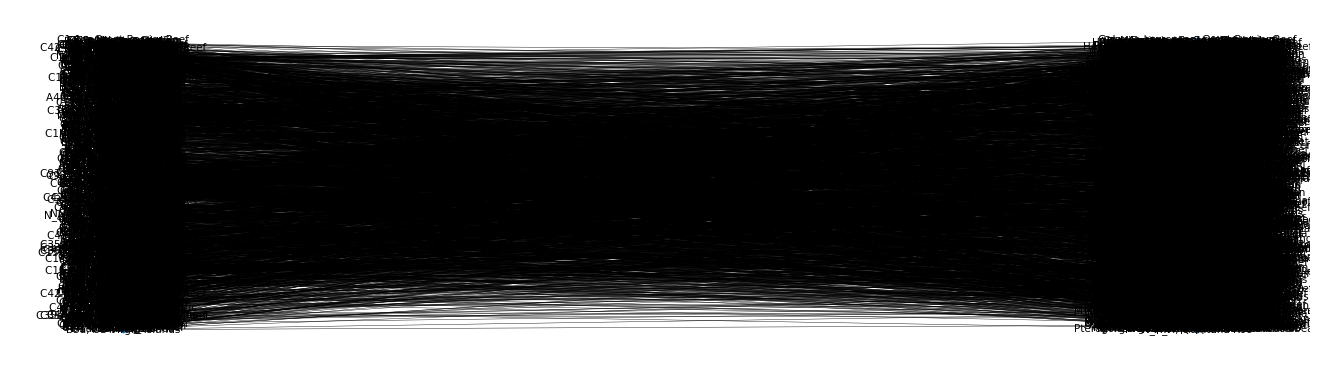

In [ ]:
#widths = list(nx.get_edge_attributes(B_1,'weight').values())
B_1_top = {n for n, d in B_1.nodes(data=True) if d["bipartite"] == 0}
pos = nx.bipartite_layout(B_1, B_1_top)
nx.draw(B_1, pos = nx.drawing.layout.bipartite_layout(B_1,B_1_top,align='vertical',scale =300, aspect_ratio = 1000), width = 0.3, node_size = 10,font_size = 7.5, with_labels = True)
plt.show()

# Gerando as componentes conexas

In [ ]:
Gcc = sorted(nx.connected_components(B_1), key=len, reverse=True)
G0 = B_1.subgraph(Gcc[0]) #0,1,2,4,10

print(G0)

Graph with 274 nodes and 415 edges


In [ ]:
G0_top = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
pos = nx.bipartite_layout(G0, G0_top)

# Parâmetros

In [ ]:
#parâmetros
r0_s = 0.25 #1
r0_h = 0.25 #1
zi = 26 #29.7
Ks = 10**4
Kh = 10**3

#grafo
G = G0

#vetor condições iniciais
y0_simb = len(G0_top)*(1000,)
y0_host = (len(G0)-len(G0_top))*(100,)
y0 = np.concatenate([y0_simb,y0_host])
num_simb = len(y0_simb)
num_host = len(y0_host)

#intervalo de tempo
t = np.linspace (0,4500,4500)

lista_temperaturas = [4 * np.cos(temp / 75 + 22) + 26 for temp in t]
print(lista_temperaturas)

[np.float64(22.000156694421452), np.float64(22.000984549607953), np.float64(22.00252364640978), np.float64(22.00477371109213), np.float64(22.007734343471597), np.float64(22.011405016987332), np.float64(22.015785078794707), np.float64(22.020873749881417), np.float64(22.02667012520604), np.float64(22.03317317385899), np.float64(22.04038173924588), np.float64(22.048294539293224), np.float64(22.056910166676452), np.float64(22.066227089070217), np.float64(22.076243649420928), np.float64(22.086958066241444), np.float64(22.09836843392795), np.float64(22.11047272309885), np.float64(22.123268780955716), np.float64(22.13675433166616), np.float64(22.150926976768623), np.float64(22.165784195598924), np.float64(22.18132334573858), np.float64(22.19754166348478), np.float64(22.214436264341916), np.float64(22.2320041435346), np.float64(22.25024217654207), np.float64(22.269147119653923), np.float64(22.28871561054699), np.float64(22.308944168883365), np.float64(22.329829196929385), np.float64(22.3513669

# Modelo de Branqueamento

In [ ]:
def taxa_cresc_max (r0_s, r0_h, G):

  lista_s = []
  lista_h = []
  bipart = nx.get_node_attributes(G, "bipartite")
  tal_s = nx.get_node_attributes(G, "simb_tol")
  tal_h = nx.get_node_attributes(G, "host_tol")
  gama = 0.01
  for i in G.nodes():
    if bipart[i] == 0:
      lista_s.append(tal_s[i])
    else:
      lista_h.append(tal_h[i])

  r_Si_max = ((r0_s)/(np.sqrt(2*np.pi)))*(np.exp(-(gama*(0))/((max(lista_s))**2)))
  r_Hi_max = ((r0_h)/(np.sqrt(2*np.pi)))*(np.exp(-(gama*(0))/((max(lista_h))**2)))

  return r_Si_max, r_Hi_max

In [ ]:
alpha_s, alpha_h = taxa_cresc_max(r0_s, r0_h, G0)
print(alpha_s*alpha_h)
print(alpha_s, alpha_h)

0.009947183943243459
0.09973557010035818 0.09973557010035818


In [ ]:
def pop_dynamics(y, t, num_simb, num_host, zi, r0_s, r0_h, alpha_s, alpha_h, Ks, Kh, G, lista_temp = lista_temperaturas, vetor_tempo = t):

  dPdt = np.zeros(num_simb + num_host)

  bipart = nx.get_node_attributes(G, "bipartite")
  tal_s = nx.get_node_attributes(G, "simb_tol")
  tal_h = nx.get_node_attributes(G, "host_tol")

  indice_tempo = np.argmin(np.abs(vetor_tempo - t))
  Ti = lista_temperaturas[indice_tempo]

  alga_nodes = [n for n in G.nodes() if bipart[n] == 0]
  host_nodes = [n for n in G.nodes() if bipart[n] == 1]

  alga_index = {n: i for i, n in enumerate(alga_nodes)}
  host_index = {n: i for i, n in enumerate(host_nodes,len(alga_nodes))}

  gama_r = 0.0008 #0.08
  gama_m = 0.002 #0.1
  mu = 0.08

  for node in G.nodes():
    if bipart[node] == 0:  # Nó do tipo alga
      i = alga_index[node]
      r_Si = ((r0_s)/(np.sqrt(2*np.pi)))*(np.exp((-gama_r*((Ti - zi)**2))/((tal_s[node])**2))) # Use node instead of i
      if Ti <= zi:
        m_Si = mu #0.05
      else:
        m_Si = 1 - (np.exp((-gama_m*((Ti - zi)**2))/((tal_s[node])**2))) + mu # Use node instead of i

      pop = max(y[i], 0)
      interaction = sum([y[host_index[j]] / max(1,G.degree(j)) for j in G.neighbors(node)])
      dPdt[i] = ((r_Si-m_Si)/Ks)*(pop/max(1,G.degree(node)))*(Ks - pop + alpha_s*(interaction)) # Use node instead of i in degree and neighbors

    else:  # Nó do tipo hospedeiro
      j = host_index[node]
      r_Hi = ((r0_h)/(np.sqrt(2*np.pi)))*(np.exp((-gama_r*((Ti - zi)**2))/((tal_h[node])**2))) # Use node instead of j
      if Ti <= zi:
        m_Hi = mu #0.05
      else:
        m_Hi = 1 - (np.exp((-gama_m*((Ti - zi)**2))/((tal_h[node])**2))) + mu # Use node instead of j

      pop = max(y[j], 0)
      interaction = sum([y[alga_index[i]] / max(1,G.degree(i)) for i in G.neighbors(node)])
      dPdt[j] = ((r_Hi-m_Hi) / Kh) * (pop /max(1,G.degree(node))) * (Kh - pop + alpha_h * (interaction)) # Use node instead of j in degree and neighbors, and assign to dHdt[j]


  return dPdt

In [ ]:
def resolver_sistema(y0,t,num_simb, num_host, zi, r0_s, r0_h, alpha_s, alpha_h, Ks, Kh, G):
    resultado = odeint(pop_dynamics, y0,t,args=(num_simb, num_host, zi, r0_s, r0_h, alpha_s, alpha_h, Ks, Kh, G))
    return resultado[:, :num_simb], resultado[:, num_simb:]

In [ ]:
ret_simb, ret_host = resolver_sistema(y0,t,num_simb, num_host, zi, r0_s, r0_h, alpha_s, alpha_h, Ks, Kh, G)

In [ ]:
count = 0
for i in ret_simb.T:
  if min(i) < 1:
    count +=1
print(f'{count}/{len(ret_simb.T)}')

count = 0
for i in ret_host.T:
  if min(i) < 1:
    count +=1
print(f'{count}/{len(ret_host.T)}')

66/76
43/198


In [ ]:
              #simb          #host
# florida     20/26          4/32
# caribe      30/36          0/61
# indico      34/43          27/131
# phuket      27/36          39/152
# gbr         66/76          43/198

# Correlação entre tolerância térmica e populações finais

## Simbiontes

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
tol_term = []
for i in G.nodes():
    if bipart[i] == 0:
      tal_s = nx.get_node_attributes(G, "simb_tol")
      tol_term.append(tal_s[i])

pop_final = []
for i in range(len(ret_simb.T)):
  #pop_final.append(ret_simb.T[i][-1])
  pop_final.append(np.log(ret_simb.T[i][-1]))

res = stats.pearsonr(tol_term, pop_final)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(0.7123923804208634), pvalue=np.float64(5.329548559519053e-13))
GBR


## Hospedeiros

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
tol_term = []
for i in G.nodes():
    if bipart[i] == 1:
      tal_s = nx.get_node_attributes(G, "host_tol")
      tol_term.append(tal_s[i])

pop_final = []
for i in range(len(ret_host.T)):
  #pop_final.append(ret_host.T[i][-1])
  pop_final.append(np.log(ret_host.T[i][-1]))

res = stats.pearsonr(tol_term, pop_final)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(0.6481174896242362), pvalue=np.float64(5.655093669155022e-25))
GBR


# Correlação entre Grau e Populações finais

## Simbiontes

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus = []
for i in G.nodes:
  if bipart[i] == 0:
    #print(i)
    k = G.degree(i)
    graus.append(k)

pop_final = []
for i in range(len(ret_simb.T)):
  #pop_final.append(ret_simb.T[i][-1])
  pop_final.append(np.log(ret_simb.T[i][-1]))


res = stats.pearsonr(graus, pop_final)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(0.17359190594234608), pvalue=np.float64(0.1337000488006232))
GBR


## Hospedeiros

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus = []
for i in G.nodes:
  if bipart[i] == 1:
    k = G.degree(i)
    graus.append(k)

pop_final = []
for i in range(len(ret_host.T)):
  #pop_final.append(ret_host.T[i][-1])
  pop_final.append(np.log(ret_host.T[i][-1]))

res = stats.pearsonr(graus, pop_final)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(0.029912835270047768), pvalue=np.float64(0.6756988964650159))
GBR


# Correlação entre Grau dos vizinhos e Populações finais

## Simbiontes

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus_sec = []
for i in G.nodes:
  if bipart[i] == 0:
    k = sum([G.degree(j) for j in G.neighbors(i)])
    graus_sec.append(k)

pop_final_simb = []
for i in range(len(ret_simb.T)):
  #pop_final_simb.append(ret_simb.T[i][-1])
  pop_final_simb.append(np.log(ret_simb.T[i][-1]))

res = stats.pearsonr(graus_sec, pop_final_simb)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(0.17149324244756725), pvalue=np.float64(0.13853633923728725))
GBR


## Hospedeiros

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus = []
for i in G.nodes:
  if bipart[i] == 1:
    k = sum([G.degree(j) for j in G.neighbors(i)])
    graus.append(k)

pop_final_host = []
for i in range(len(ret_host.T)):
  #pop_final_host.append(ret_host.T[i][-1])
  pop_final_host.append(np.log(ret_host.T[i][-1]))

res = stats.pearsonr(graus, pop_final_host)
print(res)
print("GBR")

PearsonRResult(statistic=np.float64(-0.0741496525721469), pvalue=np.float64(0.29917609524991146))
GBR


# Distribuição das populações finais


In [ ]:
Gcc = sorted(nx.connected_components(B_1), key=len, reverse=True)

G0 = B_1.subgraph(Gcc[0]) #GBR
G1 = B_1.subgraph(Gcc[1]) #Phuket
G2 = B_1.subgraph(Gcc[2]) #Índico Ocidental
G3 = B_1.subgraph(Gcc[4]) #Mar do Caribe
G4 = B_1.subgraph(Gcc[10]) #Flórida

y0_G0 = np.concatenate([76*(1000,),198*(100,)])
y0_G1 = np.concatenate([36*(1000,),152*(100,)])
y0_G2 = np.concatenate([43*(1000,),131*(100,)])
y0_G3 = np.concatenate([36*(1000,),61*(100,)])
y0_G4 = np.concatenate([26*(1000,),32*(100,)])

G0_top, G0_bot = resolver_sistema(y0_G0, t, 76, 198, zi, r0_s, r0_h, taxa_cresc_max(r0_s, r0_h, G0)[0], taxa_cresc_max(r0_s, r0_h, G0)[1], Ks, Kh, G0)
G1_top, G1_bot = resolver_sistema(y0_G1, t, 36, 152, zi, r0_s, r0_h, taxa_cresc_max(r0_s, r0_h, G1)[0], taxa_cresc_max(r0_s, r0_h, G1)[1], Ks, Kh, G1)
G2_top, G2_bot = resolver_sistema(y0_G2, t, 43, 131, zi, r0_s, r0_h, taxa_cresc_max(r0_s, r0_h, G2)[0], taxa_cresc_max(r0_s, r0_h, G2)[1], Ks, Kh, G2)
G3_top, G3_bot = resolver_sistema(y0_G3, t, 36, 61, zi, r0_s, r0_h, taxa_cresc_max(r0_s, r0_h, G3)[0], taxa_cresc_max(r0_s, r0_h, G3)[1], Ks, Kh, G3)
G4_top, G4_bot = resolver_sistema(y0_G4, t,26, 32, zi, r0_s, r0_h, taxa_cresc_max(r0_s, r0_h, G4)[0], taxa_cresc_max(r0_s, r0_h, G4)[1], Ks, Kh, G4)

In [ ]:
import os

# --- Definir o Caminho no Google Drive ---
# Você pode escolher qualquer pasta no seu Drive.
# Se a pasta 'dados_corais' não existir, ela será criada.
drive_path = '/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/'
os.makedirs(drive_path, exist_ok=True) # Garante que a pasta exista

# --- Salvar todas as variáveis em um único arquivo .npz ---
# Cada variável é salva com seu nome como chave dentro do arquivo .npz.
np.savez(f'{drive_path}resultados_corais_2modelo[ATUALIZADO].npz',
          G0_top=G0_top, G0_bot=G0_bot,
          G1_top=G1_top, G1_bot=G1_bot,
          G2_top=G2_top, G2_bot=G2_bot,
          G3_top=G3_top, G3_bot=G3_bot,
          G4_top=G4_top, G4_bot=G4_bot)

print(f"✅ Todos os dados foram salvos com sucesso em: {drive_path}resultados_corais.npz")
print("Você pode verificar este arquivo no seu Google Drive.")

✅ Todos os dados foram salvos com sucesso em: /content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/resultados_corais.npz
Você pode verificar este arquivo no seu Google Drive.


In [ ]:
# --- Definir o Caminho do Arquivo no Google Drive ---
# Certifique-se de que este caminho corresponde ao local onde você salvou o arquivo.
drive_path = '/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/'
file_name = 'resultados_corais_2modelo[ATUALIZADO].npz'
full_path = f'{drive_path}{file_name}'

# --- Carregar os dados do arquivo .npz ---
# O np.load retorna um objeto que se comporta como um dicionário.
try:
    dados_carregados = np.load(full_path)

    # --- Atribuir os dados carregados às suas variáveis originais ---
    G0_top = dados_carregados['G0_top']
    G0_bot = dados_carregados['G0_bot']
    G1_top = dados_carregados['G1_top']
    G1_bot = dados_carregados['G1_bot']
    G2_top = dados_carregados['G2_top']
    G2_bot = dados_carregados['G2_bot']
    G3_top = dados_carregados['G3_top']
    G3_bot = dados_carregados['G3_bot']
    G4_top = dados_carregados['G4_top']
    G4_bot = dados_carregados['G4_bot']

    print(f"✅ Dados carregados com sucesso de: {full_path}")
    print(f"Exemplo - Formato de G0_top: {G0_top.shape}")
    print(f"Exemplo - Formato de G1_bot: {G1_bot.shape}")

    # É uma boa prática fechar o objeto npzfile para liberar recursos
    dados_carregados.close()

except FileNotFoundError:
    print(f"❌ Erro: O arquivo '{file_name}' não foi encontrado em '{drive_path}'.")
    print("Por favor, verifique se o caminho e o nome do arquivo estão corretos no seu Google Drive.")
except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")

✅ Dados carregados com sucesso de: /content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/resultados_corais_2modelo[ATUALIZADO].npz
Exemplo - Formato de G0_top: (4500, 76)
Exemplo - Formato de G1_bot: (4500, 152)


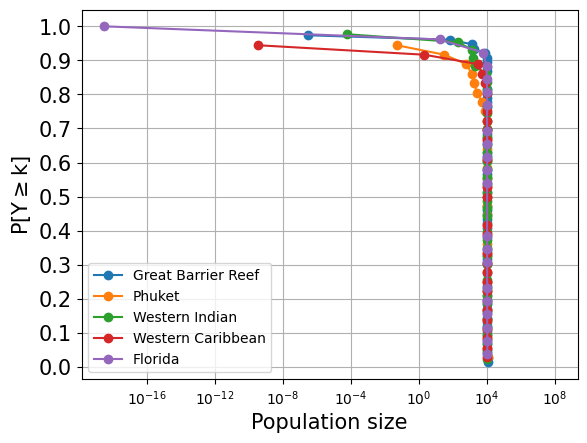

In [ ]:
pop_sequence_simb_0 = sorted([G0_top.T[i][-1] for i in range(len(G0_top.T))], reverse=True)
popmax_simb_0 = max(pop_sequence_simb_0)
pop_sequence_simb_1 = sorted([G1_top.T[i][-1] for i in range(len(G1_top.T))], reverse=True)
popmax_simb_1 = max(pop_sequence_simb_1)
pop_sequence_simb_2 = sorted([G2_top.T[i][-1] for i in range(len(G2_top.T))], reverse=True)
popmax_simb_2 = max(pop_sequence_simb_2)
pop_sequence_simb_3 = sorted([G3_top.T[i][-1] for i in range(len(G3_top.T))], reverse=True)
popmax_simb_3 = max(pop_sequence_simb_3)
pop_sequence_simb_4 = sorted([G4_top.T[i][-1] for i in range(len(G4_top.T))], reverse=True)
popmax_simb_4 = max(pop_sequence_simb_4)


fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista = [pop_sequence_simb_0,pop_sequence_simb_1,pop_sequence_simb_2,pop_sequence_simb_3,pop_sequence_simb_4]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]

# Define o limite mínimo para as populações
limite_minimo_populacao = 1e-20

for i in range(len(lista)):
    popCount = collections.Counter(lista[i])
    pop_f, cnt = zip(*popCount.items())
    cnt_c = [ti/len(lista[i]) for ti in cnt]
    cs = np.cumsum(cnt_c)

    # Converte para arrays NumPy para facilitar a filtragem
    pop_f = np.array(pop_f)
    cs = np.array(cs)

    # Filtra os dados: mantém apenas as populações maiores ou iguais ao limite
    mascara = pop_f >= limite_minimo_populacao
    pop_f_filtrada = pop_f[mascara]
    cs_filtrada = cs[mascara]

    plt.plot(pop_f_filtrada, cs_filtrada, "-o", label = legenda[i])

#plt.title("CCDF Final Populations - Symbionts")
plt.scatter(10e7,1,color="white")
plt.scatter(10e-18,1,color="white")
#plt.scatter(99999999,1,color="white")
plt.ylabel("P[Y$\geq$k]",color = "black", fontsize = 15)
plt.xlabel("Population size",color = "black", fontsize = 15)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],color = "black", fontsize = 15)
plt.xscale("log")
plt.yticks(fontsize = 15)
plt.legend()
plt.grid()
plt.show()
#print("Desvio Padrão dos graus dos simbiontes: " + str(np.std(degree_sequence_simb_1)))
#print("Média dos graus dos simbiontes: " + str(np.mean(degree_sequence_simb_1)))

## Hospedeiros

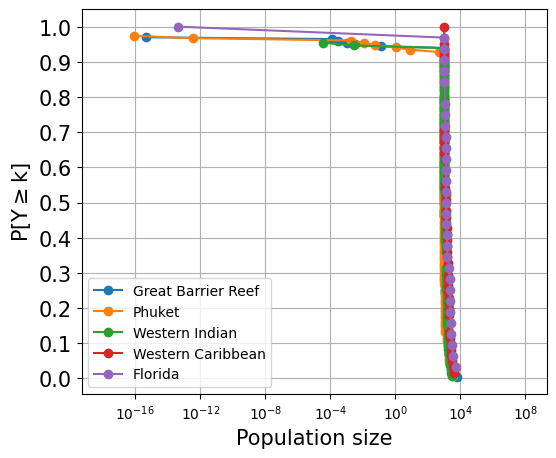

In [ ]:
pop_sequence_host_0 = sorted([G0_bot.T[i][-1] for i in range(len(G0_bot.T))], reverse=True)
popmax_host_0 = max(pop_sequence_host_0)
pop_sequence_host_1 = sorted([G1_bot.T[i][-1] for i in range(len(G1_bot.T))], reverse=True)
popmax_host_1 = max(pop_sequence_host_1)
pop_sequence_host_2 = sorted([G2_bot.T[i][-1] for i in range(len(G2_bot.T))], reverse=True)
popmax_host_2 = max(pop_sequence_host_2)
pop_sequence_host_3 = sorted([G3_bot.T[i][-1] for i in range(len(G3_bot.T))], reverse=True)
popmax_host_3 = max(pop_sequence_host_3)
pop_sequence_host_4 = sorted([G4_bot.T[i][-1] for i in range(len(G4_bot.T))], reverse=True)
popmax_host_4 = max(pop_sequence_host_4)


fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista = [pop_sequence_host_0,pop_sequence_host_1,pop_sequence_host_2,pop_sequence_host_3,pop_sequence_host_4]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
# Define o limite mínimo para as populações
limite_minimo_populacao = 1e-20

for i in range(len(lista)):
    popCount = collections.Counter(lista[i])
    pop_f, cnt = zip(*popCount.items())
    cnt_c = [ti/len(lista[i]) for ti in cnt]
    cs = np.cumsum(cnt_c)

    # Converte para arrays NumPy para facilitar a filtragem
    pop_f = np.array(pop_f)
    cs = np.array(cs)

    # Filtra os dados: mantém apenas as populações maiores ou iguais ao limite
    mascara = pop_f >= limite_minimo_populacao
    pop_f_filtrada = pop_f[mascara]
    cs_filtrada = cs[mascara]

    plt.plot(pop_f_filtrada, cs_filtrada, "-o", label = legenda[i])

#plt.title("CCDF Final Populations - Symbionts")
plt.scatter(10e7,1,color="white")
plt.scatter(10e-19,1,color="white")
#plt.scatter(99999999,1,color="white")
plt.ylabel("P[Y$\geq$k]",color = "black", fontsize = 15)
plt.xlabel("Population size",color = "black", fontsize = 15)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],color = "black", fontsize = 15)
plt.xscale("log")
plt.yticks(fontsize = 15)
plt.legend()
plt.grid()
plt.show()
#print("Desvio Padrão dos graus dos simbiontes: " + str(np.std(degree_sequence_simb_1)))
#print("Média dos graus dos simbiontes: " + str(np.mean(degree_sequence_simb_1)))

# Comparação entre simbiontes iguais

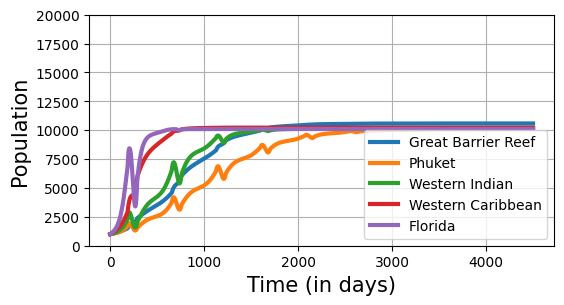

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

lista_D1 = [G0_top.T[3],G1_top.T[32],G2_top.T[39],G3_top.T[19],G4_top.T[2]]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista_D1)):
  plt.plot(t, lista_D1[i],label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend(loc="best")
#plt.title("Population dynamics of the symbiont D1 in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,22500,2500))
plt.grid()
plt.show()

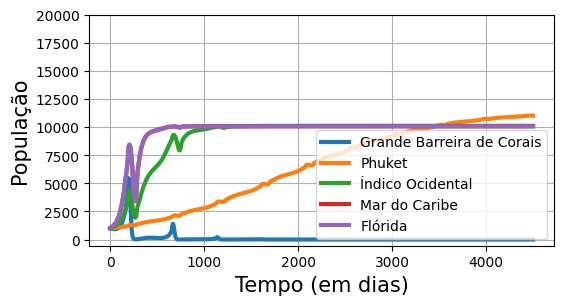

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

lista_C1 = [G0_top.T[60],G1_top.T[10],G2_top.T[37],G3_top.T[3],G4_top.T[18]]
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Mar do Caribe", "Flórida"]

for i in range(len(lista_C1)):
  plt.plot(t, lista_C1[i], label = legenda[i], linewidth = 3)


plt.ylabel("População",color = "black", fontsize = 15)
plt.xlabel("Tempo (em dias)",color = "black", fontsize = 15)
#plt.ylabel("Population",color = "black", fontsize = 15)
#plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the symbiont C1 in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,22500,2500))
plt.grid()
plt.show()

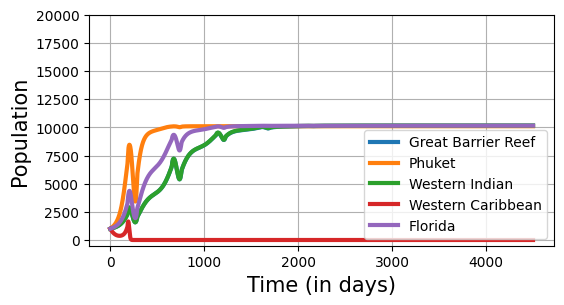

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

lista_C3 = [G0_top.T[20],G1_top.T[13],G2_top.T[3],G3_top.T[18],G4_top.T[10]]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista)):
  plt.plot(t, lista_C3[i], label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the symbiont C3 in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,22500,2500))
plt.grid()
plt.show()

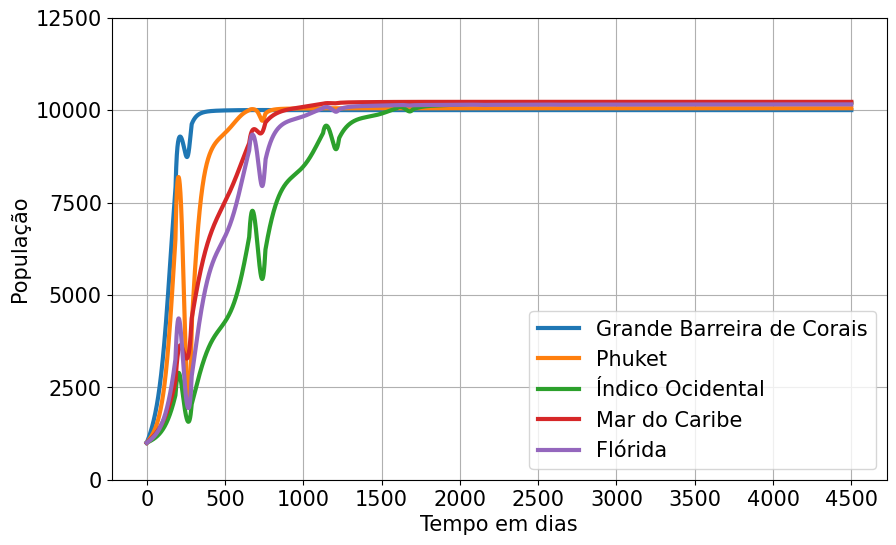

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)

lista_D1a = [G0_top.T[25],G1_top.T[21],G2_top.T[26],G3_top.T[5],G4_top.T[11]]
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Mar do Caribe", "Flórida"]
for i in range(len(lista_D1a)):
  plt.plot(t, lista_D1a[i], label = legenda[i],  linewidth = 3)

plt.ylabel("População",color = "black", fontsize = 15)
plt.xlabel("Tempo em dias",color = "black", fontsize = 15)
plt.legend(fontsize=15)
#plt.title("Population dynamics of the symbiont D1a in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,15000,2500),fontsize = 15)
plt.xticks(range(0,5000,500), fontsize = 15)
plt.grid()
plt.show()

# Comparação entre hospedeiros iguais

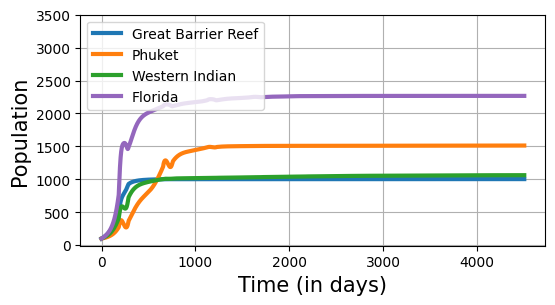

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

#lista_PD = [G0_bot.T[232],G1_bot.T[124],G2_bot.T[54],G4_bot.T[55]]
lista_PD = [G0_bot.T[232-76],G1_bot.T[124-36],G2_bot.T[54-43],G4_bot.T[55-26]]

colors = ['C0', 'C1', 'C2', 'C4']
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Florida"]
for i in range(len(lista_PD)):
  plt.plot(t, lista_PD[i], color = colors[i], label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the host $Pocillopora$ $damicornis$\n in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,3600,500))
plt.grid()
plt.show()

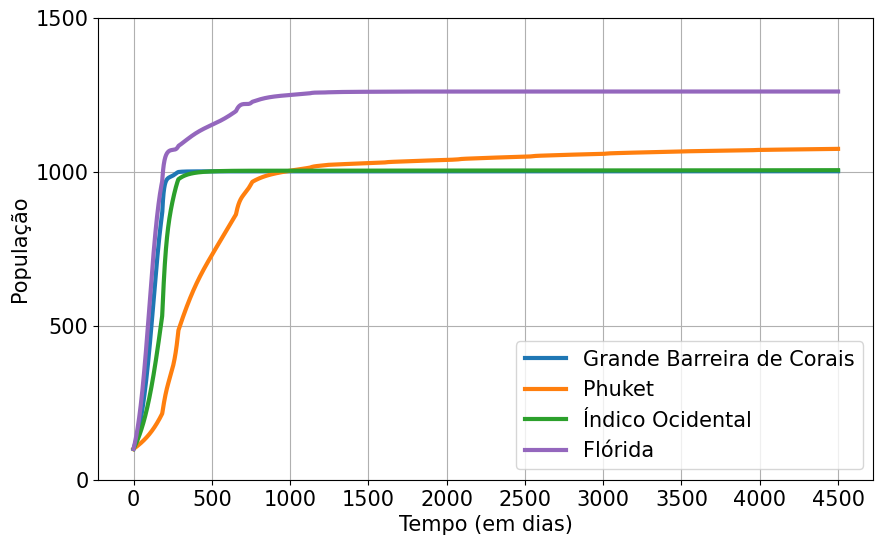

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)

#lista_AT = [G0_bot.T[240],G1_bot.T[75],G2_bot.T[57],G4_bot.T[31]]
lista_AT = [G0_bot.T[240-76],G1_bot.T[75-36],G2_bot.T[57-43],G4_bot.T[31-26]]

colors = ['C0', 'C1', 'C2', 'C4']
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Flórida"]
for i in range(len(lista_AT)):
  plt.plot(t, lista_AT[i], color = colors[i], label = legenda[i], linewidth = 3)

plt.ylabel("População",color = "black", fontsize = 15)
plt.xlabel("Tempo (em dias)",color = "black", fontsize = 15)
plt.legend(fontsize = 15)
#plt.title("Population dynamics of the host $Acropora$ $tenuis$ \n in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,2000,500), fontsize=15)
plt.xticks(range(0,5000, 500),fontsize=15)
plt.grid()
plt.show()

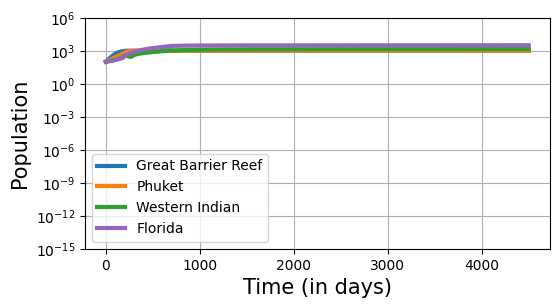

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

#lista_AV = [G0_bot.T[96],G1_bot.T[123],G2_bot.T[79],G4_bot.T[53]]
lista_AV = [G0_bot.T[96-76],G1_bot.T[123-36],G2_bot.T[79-43],G4_bot.T[53-26]]

colors = ['C0', 'C1', 'C2', 'C4']
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Florida"]
for i in range(len(lista_AV)):
  plt.plot(t, lista_AV[i], color = colors[i],label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the host $Acropora$ $valida$ \n in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,3600,500))
plt.grid()
plt.show()

# Análise do Delta

## Simbiontes

In [ ]:
def delta(zi, r0_s, tal_s):

  lista_delta = []
  bipart = nx.get_node_attributes(G, "bipartite")
  tempo = np.linspace(0,1500,1500)
  gama = .08

  for t in tempo:
    Ti = (4)*np.cos(t/75 + 22) + 26
    r_Si = ((r0_s)/(np.sqrt(2*np.pi*(tal_s)**2)))*(np.exp((-gama*(np.abs(Ti - zi)))/((tal_s)**2)))
    if Ti <= zi:
      m_Si = 0.04
    else:
      m_Si = 1 - (np.exp((-(np.abs(Ti - zi)))/((tal_s)**2)))
    delta = r_Si - m_Si
    lista_delta.append(delta)

  return np.array(lista_delta)

In [ ]:
lista = []
bipart = nx.get_node_attributes(G, "bipartite")
tal_s = nx.get_node_attributes(G, "simb_tol")
for i in G.nodes():
  if bipart[i] == 0:
    lista.append(tal_s[i])

print(min(lista))
print(max(lista))
t_delta = np.linspace(0,1500,1500)
simb_min = delta(zi, 1,  min(lista))
simb_max = delta(zi, 1,  max(lista))

0.281
0.843


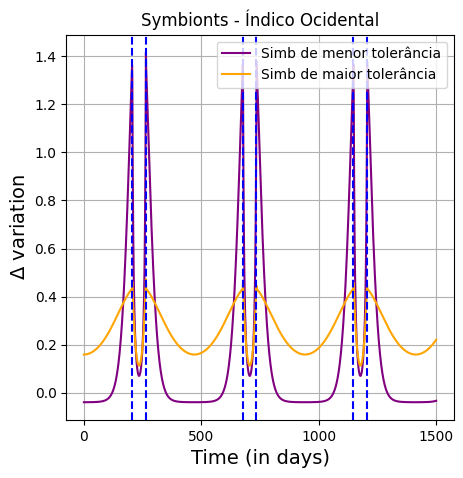

In [ ]:
#plotagem
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (5,5)
plt.plot(t_delta,simb_min, color = "purple", label = "Simb de menor tolerância")
plt.plot(t_delta,simb_max, color = "orange", label = "Simb de maior tolerância") #,label = lista_nomes_host[i])
plt.title("Symbionts - " + reg)
plt.xlabel('Time (in days)', color = "black",fontsize = 14)
plt.ylabel('$\Delta$ variation', color = "black",fontsize = 14)
plt.axvline(x=205, color = "blue",linestyle='--')
plt.axvline(x=263, color = "blue",linestyle='--')
plt.axvline(x=676, color = "blue",linestyle='--')
plt.axvline(x=734, color = "blue",linestyle='--')
plt.axvline(x=1147, color ="blue",linestyle='--')
plt.axvline(x=1205, color = "blue",linestyle='--')
plt.xticks(range(0,2000,500),color = "black")
plt.legend()
plt.grid()
plt.show()

## Hospedeiros

In [ ]:
def delta(zi, r0_h, tal_h):

  lista_delta = []

  tempo = np.linspace(0,1500,1500)
  gama = 0.1

  for t in tempo:
    Ti = (4)*np.cos(t/75 + 22) + 26
    r_Si = ((r0_s)/(np.sqrt(2*np.pi*(tal_h)**2)))*(np.exp((-gama*(np.abs(Ti - zi)))/((tal_h)**2)))
    if Ti <= zi:
      m_Si = 0.04
    else:
      m_Si = 1 - (np.exp((-(np.abs(Ti - zi)))/((tal_h)**2)))
    delta = r_Si - m_Si
    lista_delta.append(delta)

  return np.array(lista_delta)

In [ ]:
lista = []
bipart = nx.get_node_attributes(G, "bipartite")
tal_h = nx.get_node_attributes(G, "host_tol")
for i in G.nodes():
  if bipart[i] == 1:
    lista.append(tal_h[i])

print(min(lista))
print(max(lista))
t_delta = np.linspace(0,1500,1500)
host_min = delta(zi, 1, min(lista))
host_max = delta(zi, 1, max(lista))

0.285
0.99


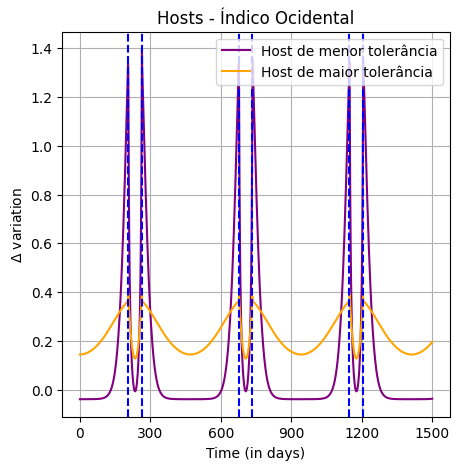

In [ ]:
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (5,5)
plt.plot(t_delta,host_min, color = "purple", label = "Host de menor tolerância")
plt.plot(t_delta,host_max, color = "orange", label = "Host de maior tolerância")
plt.title("Hosts - " + reg)
plt.xlabel('Time (in days)', color = "black")#,fontsize = 14)
plt.ylabel('$\Delta$ variation', color = "black")#,fontsize = 14)
plt.axvline(x=205, color = "blue",linestyle='--')
plt.axvline(x=263, color = "blue",linestyle='--')
plt.axvline(x=676, color = "blue",linestyle='--')
plt.axvline(x=734, color = "blue",linestyle='--')
plt.axvline(x=1147, color ="blue",linestyle='--')
plt.axvline(x=1205, color = "blue",linestyle='--')
plt.xticks(range(0,1600,300),color = "black")
plt.legend()
plt.grid()
plt.show()

# Modelo de temperatura

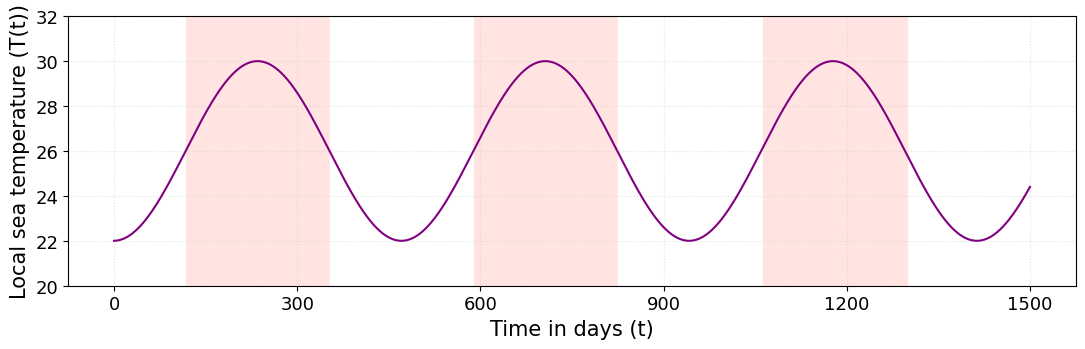

In [ ]:
lista_Tz = []
t = np.linspace (0, 1500,1500)
for tempo in t:
  Ti = (4)*np.cos(tempo/75 + 22) + 26
  lista_Tz.append(Ti)

plt.rcParams['figure.figsize'] = (13,3.5)
plt.plot(t,lista_Tz,color = "purple")

plt.ylabel('Local sea temperature (T(t))',color = "black", fontsize = 15) #eixo y legenda
plt.xlabel('Time in days (t)',color = "black", fontsize = 15) #eixo x legenda

x_points = [118, 354, 590, 826, 1062, 1298]

# Cores para alternar o preenchimento (opcional, mas fica visualmente melhor)
colors = ['mistyrose', 'white']
alpha_value = 1

# Loop para preencher as áreas entre os pontos
# O primeiro preenchimento vai de x_points[0] até x_points[1], o segundo de x_points[1] até x_points[2], e assim por diante.
for i in range(len(x_points) - 1):
    plt.axvspan(x_points[i], x_points[i+1], color=colors[i % len(colors)], alpha=alpha_value)

plt.yticks(range(20,33,2), fontsize = 13)
plt.xticks(np.linspace(0, 1500,6), fontsize = 13)
plt.grid(color='lightgray', linestyle=':', alpha=0.65)
plt.show()